In [2]:
# GPU availability
import tensorflow as tf
print('tf version {}'.format(tf.__version__))
print('Is GPU available {}'.format(tf.test.is_gpu_available()))
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))

tf version 1.13.1
Is GPU available False


In [3]:
# gym specifications
import gym
import time 
env_name = 'CartPole-v0'
env_name = 'Breakout-v0'
env_name = 'Pong-v0'
env = gym.make(env_name)
print(env_name)
print('observation dimensionality {}'.format(env.observation_space.shape ))
print('number of actions {}'.format(env.action_space.n))
print('meaning of actions {}'.format(env.unwrapped.get_action_meanings()))

Pong-v0
observation dimensionality (210, 160, 3)
number of actions 6
meaning of actions ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [7]:
# Train a model
%load_ext autoreload
%autoreload 2
import gym
import os
import matplotlib 
%matplotlib inline
from model import Model
from cfg import get_cfg
from utils import get_experiment_name
from utils import dotdict
import tensorflow as tf
tf.reset_default_graph()

# where to save experimental results
experiments_folder = os.path.join(os.getcwd(), 'results')
experiment_name, experiment_folder = get_experiment_name(experiments_folder)

# specify environment
env_name = 'four_rooms_maze'
env_name = 'BreakoutNoFrameskip-v4'
env_name = 'PongNoFrameskip-v4'
env_name = 'CartPole-v0'

# specify agent
agent_name = 'ppo'
agent_name = 'dqn'
agent_name = 'vpg'

# load default config parameters
cfg_env, cfg_agent = get_cfg(experiment_folder, env_name, agent_name)
cfg = cfg_env
cfg.update(cfg_agent)
cfg = dotdict(cfg)

# modify default config parameters
cfg.n_steps = 20000
cfg.batch_size = 1
cfg.log_step = 2000
cfg.agent_buffer_start_size = 1000
cfg.save_freq = 20000
cfg.verbose = False
cfg.update_target_network_freq = 10

# train model
model = Model(cfg)
model.train_model()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
ep 106 st 2000 vpg e.ret.tr 20.40 ep.ln 20 sp 0.0 ag.ls 5.37 bs.ls 132.10 
ep 195 st 4000 vpg e.ret.tr 24.85 ep.ln 25 sp 1863.8 ag.ls 5.24 bs.ls 189.15 
ep 278 st 6000 vpg e.ret.tr 28.00 ep.ln 28 sp 1812.7 ag.ls 5.15 bs.ls 199.28 
ep 351 st 8000 vpg e.ret.tr 29.55 ep.ln 30 sp 2047.4 ag.ls 4.69 bs.ls 187.01 
ep 414 st 10000 vpg e.ret.tr 39.50 ep.ln 40 sp 2095.9 ag.ls 5.34 bs.ls 283.28 
ep 467 st 12000 vpg e.ret.tr 33.45 ep.ln 33 sp 2148.2 ag.ls 3.66 bs.ls 171.93 
ep 519 st 14000 vpg e.ret.tr 42.90 ep.ln 43 sp 2158.7 ag.ls 4.52 bs.ls 234.45 
ep 555 st 16000 vpg e.ret.tr 56.70 ep.ln 57 sp 2228.5 ag.ls 5.16 bs.ls 394.47 
ep 585 st 18000 vpg e.ret.tr 69.65 ep.ln 70 sp 2223.5 ag.ls 5.78 bs.ls 512.36 
ep 608 st 20000 vpg e.ret.tr 87.95 ep.ln 88 sp 1705.4 ag.ls 6.14 bs.ls 754.67 


In [66]:
# Load pretrained model
%load_ext autoreload
%autoreload 2
import os
from model import Model
import tensorflow as tf
tf.reset_default_graph()

dpath = os.path.join(os.getcwd(), 'results_train/vpg/Model')
model = Model.load(dpath)

# continue training
#model.train_model()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:tensorflow:Restoring parameters from /Users/raoul/code/drl/results_train/vpg/Model/vpg_ckpt-2536


INFO:tensorflow:Restoring parameters from /Users/raoul/code/drl/results_train/vpg/Model/vpg_ckpt-2536


INFO:tensorflow:Restoring parameters from /Users/raoul/code/drl/results_train/vpg/Model/baseline_ckpt-2536


INFO:tensorflow:Restoring parameters from /Users/raoul/code/drl/results_train/vpg/Model/baseline_ckpt-2536


In [62]:
# Simulate episodes in OpenAI gym
import time 
import matplotlib
%matplotlib inline
n_steps, n_plays, rewards = 0, 0, []
for _ in range(1000):
    obs, ext_return, done = model.env.reset(), 0., False
    while not done:
        obs = model.encode_obs(obs)
        action = model.action(obs, 0.)
        obs, r, done, info = model.env.step(action)
        rewards.append(r)
        n_steps += 1
        #if n_steps % 4 == 0:
        #    model.env.render('gif/{}.png'.format(1000 + n_steps))
        #time.sleep(0.01)
    n_plays += 1
pos_reward_ratio = sum([r for r in rewards if r > 0]) / n_plays
print(n_plays, n_steps, pos_reward_ratio)
model.env.close()

1000 95904 1.0


In [6]:
# Make gif
import os 
import imageio
images = []
experiment_folder = os.path.join(os.getcwd(), 'gif')
fnames = os.listdir(experiment_folder)
fnames = sorted([fname for fname in fnames if '.png' in fname])
for fname in fnames:
    fname = os.path.join(experiment_folder, fname)
    images.append(imageio.imread(fname))
imageio.mimsave('gif/pong_not_preprocessed.gif', images, duration=0.20)

In [68]:
# Tensorflow events to csv files
from utils import tf_events_to_csv
from utils import subdir_paths
experiment_folder = os.path.join(os.getcwd(), 'results_train/vpg')
for dpath in subdir_paths(experiment_folder):
    tf_events_to_csv(dpath)

<Figure size 432x288 with 0 Axes>

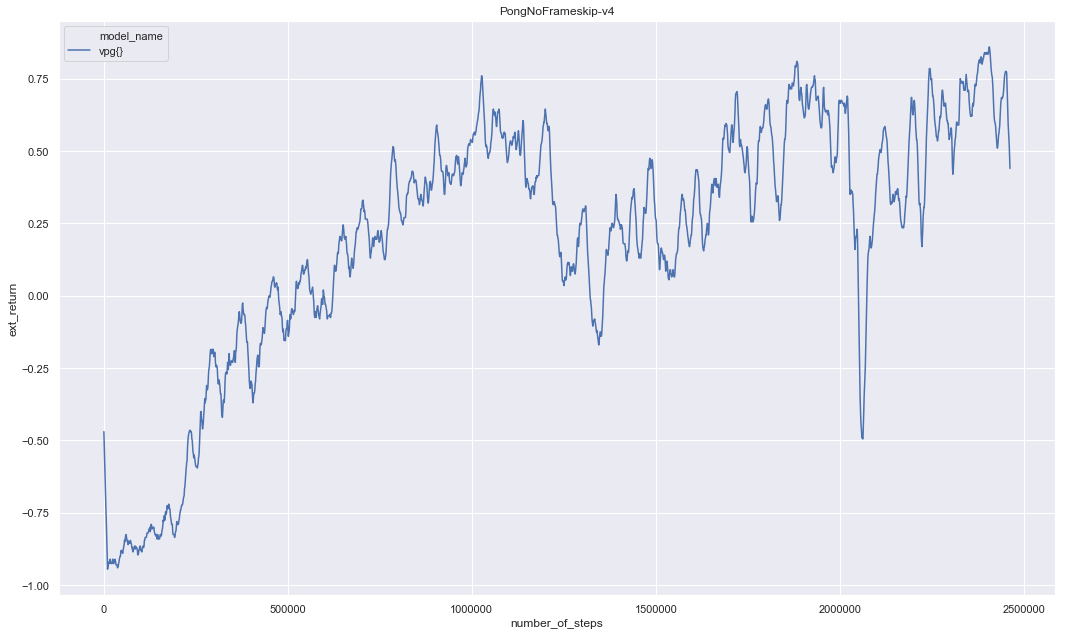

In [70]:
# Hyperparameter Plots
import os
from utils import plot_hp_sensitivities
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

experiment_folder = os.path.join(os.getcwd(), 'results_train/vpg')
plot_hp_sensitivities(experiment_folder, 'ext_return', 'model_name',{}, details=False, box_pts=20, show=True)